## Imports

In [1]:
# standard library
import sys, copy

# external packages
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt

# local packages
from utils import add_ids 
from class_split_data_loader import ClassSplitDataLoader
from autoencoder import Autoencoder

## Setup

In [2]:
settings = {
    'criterion' : nn.MSELoss(),
    'epochs' : 20,
    'n_encoders' : 3,
    'input_size' : 784,
    'hidden_sizes_encoder' : [512, 256],
    'hidden_sizes_decoder' : [256, 512],
    'encoded_size' : 128,
}

In [3]:
# import data
data_train = add_ids(MNIST)(".", download=True, transform=ToTensor())
data_test  = add_ids(MNIST)(".", train=False, download=True, transform=ToTensor())

In [4]:
# and create dataloaders
dataloaders = []
dataloaders_test = []
for k in range(settings['n_encoders']):
    dataloader = ClassSplitDataLoader(data_train, class_to_keep=k, remove_data=False, keep_order=True, batch_size=128) 
    dataloaders.append(dataloader)
    dataloader = ClassSplitDataLoader(data_test, class_to_keep=k, remove_data=False, keep_order=True, batch_size=128) 
    dataloaders_test.append(dataloader)
    # partition_dataset uses by default "remove_data=True, keep_order=False"

# and add them to the settings
settings['dataloaders'] = dataloaders
settings['dataloaders_test'] = dataloaders_test

## Creating the network

In [5]:
net = Autoencoder(settings)

## Train the network

In [6]:
train_perf, test_perf = [], []
for i in range(settings['epochs']):
    
    running_loss = np.zeros(settings['n_encoders'])
    running_test_MSE = np.zeros(settings['n_encoders'])
    
    for k in range(settings['n_encoders']):
        loss_train, loss_test = net.iter_training_one_encoder(k)
        running_loss[k] += loss_train
        running_test_MSE[k] += loss_test
    
    print(f"Epoch {i}/{settings['epochs']}"
            +f" - Training loss: {np.average(running_loss)/settings['n_encoders']:.4f}"
            +f" - testing MSE: {np.average(running_test_MSE)/settings['n_encoders']:.4f}")
    train_perf.append(running_loss/settings['n_encoders'])
    test_perf.append(running_test_MSE/settings['n_encoders'])


Epoch 0/20 - Training loss: 0.0374 - testing MSE: 0.0366
Epoch 1/20 - Training loss: 0.0365 - testing MSE: 0.0363
Epoch 2/20 - Training loss: 0.0363 - testing MSE: 0.0361
Epoch 3/20 - Training loss: 0.0361 - testing MSE: 0.0361
Epoch 4/20 - Training loss: 0.0361 - testing MSE: 0.0360
Epoch 5/20 - Training loss: 0.0360 - testing MSE: 0.0360
Epoch 6/20 - Training loss: 0.0360 - testing MSE: 0.0359
Epoch 7/20 - Training loss: 0.0359 - testing MSE: 0.0358
Epoch 8/20 - Training loss: 0.0359 - testing MSE: 0.0358
Epoch 9/20 - Training loss: 0.0358 - testing MSE: 0.0358
Epoch 10/20 - Training loss: 0.0358 - testing MSE: 0.0358
Epoch 11/20 - Training loss: 0.0358 - testing MSE: 0.0358
Epoch 12/20 - Training loss: 0.0358 - testing MSE: 0.0357
Epoch 13/20 - Training loss: 0.0358 - testing MSE: 0.0357
Epoch 14/20 - Training loss: 0.0357 - testing MSE: 0.0357
Epoch 15/20 - Training loss: 0.0357 - testing MSE: 0.0357
Epoch 16/20 - Training loss: 0.0357 - testing MSE: 0.0357
Epoch 17/20 - Training l

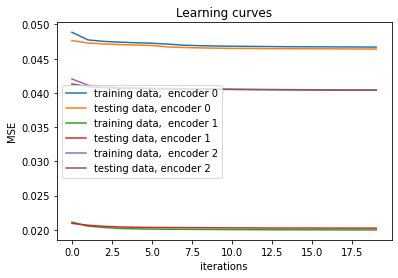

In [7]:
fig = plt.figure()
ax = plt.axes()
train_perf, test_perf = np.array(train_perf), np.array(test_perf)
x = range(settings['epochs'])
for k in range(settings['n_encoders']):
    ax.plot(x, train_perf[:,k], label=f'training data,  encoder {k}')
    ax.plot(x, test_perf[:,k], label=f'testing data, encoder {k}')

plt.title("Learning curves")
plt.xlabel("iterations")
plt.ylabel("MSE")
plt.legend()
plt.show()